# c_beta Analysis

In [ ]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import MolecularClocks.src.methylation_util as m_util
from MolecularClocks.src.invasiveCpGs_consts import getConsts

consts = getConsts(['gene_module_dict', 'all_module_genes'])

In [ ]:
figure_outdir = 'figures'
if not os.path.exists(figure_outdir):
    os.mkdir(figure_outdir)

## Prep data

In [ ]:
TCGA_clinical_dir = os.path.join(consts['official_indir'], 'TCGA')
TCGA_c_beta_dir = os.path.join(consts['repo_dir'], 'Select_fCpGs', 'outputs')
Ringner_clinical_dir = os.path.join(consts['official_indir'], 'Ringner')
Ringner_c_beta_dir = os.path.join(consts['repo_dir'], 'Process_Other_Data_Sources', 'outputs', 'cohort_T2')

In [ ]:
clinical = {}

In [ ]:
# Import step for ringner data

clinical['ringner'] = pd.read_table(os.path.join(Ringner_clinical_dir, 'cohort.T2.clinical.txt'), index_col=0, dtype={'grade':str})
clinical['ringner']['c_beta'] = pd.read_table(os.path.join(Ringner_c_beta_dir, 'cohort.T2.c_beta.txt'), index_col=0).squeeze("columns")
clinical['ringner']['grade'] = clinical['ringner']['grade'].map({'1':'Grade 1', '2':'Grade 2', '3':'Grade 3'}).fillna(value='None')

In [ ]:
# Initial import step for TCGA data

clinical['TCGA'] = pd.read_table(os.path.join(TCGA_clinical_dir, 'cohort1.clinical.tsv'), index_col=0)
clinical['TCGA'] = clinical['TCGA'].set_index('bcr_patient_barcode')
c_beta_tcga = pd.read_table(os.path.join(TCGA_c_beta_dir, 'cohort.T1.c_beta.txt'), index_col=0, header=None).squeeze("columns")
c_beta_tcga.index = c_beta_tcga.index.to_series().apply(consts['sampleIDtoPatientID'])
clinical['TCGA']['c_beta'] = c_beta_tcga

clinical['TCGA']['T Stage'] = clinical['TCGA']['ajcc_pathologic_t'].dropna().apply(lambda x:x[:2])
clinical['TCGA']['Stage'] = clinical['TCGA']['ajcc_pathologic_stage'].dropna().str.rstrip('ABC')
clinical['TCGA']['age'] = clinical['TCGA']['age_at_diagnosis'] / 365

### IHC status

In [ ]:
# Import and process table with hormone status 

marker_state_dict = {
#                      'Equivocal':float('NaN'),
                     'Equivocal':'Positive',
                     'Indeterminate':float('NaN'),
                     'Negative':'Negative', 'Positive':'Positive'}
ihc_status = pd.read_table(os.path.join(TCGA_clinical_dir, 'nationwidechildrens.org_clinical_patient_brca.txt'),
                           usecols=['bcr_patient_barcode', 'her2_status_by_ihc', 'er_status_by_ihc', 'pr_status_by_ihc'],
                           index_col=0, na_values=['[Not Evaluated]', '[Not Available]']).iloc[2:]
ihc_status = ihc_status.apply(lambda col:col.map(marker_state_dict), axis=0)
assert not ihc_status.index.duplicated().any()
assert ihc_status.index.isin(clinical['TCGA'].index).all()

In [ ]:
# IGNORE

# print('All BRCA cases')
# display(ihc_status.apply(lambda x:x.value_counts()).fillna(0))

# analysis_submitterIDs = clinical['TCGA'].index[clinical['TCGA']['in_analysis_dataset']]
# print('Pure ductal cases')
# display(ihc_status.loc[analysis_submitterIDs].apply(lambda x:x.value_counts()).fillna(0))

# # display(ihc_status.loc[ihc_status['her2_status_by_ihc']=='Equivocal'].groupby('er_status_by_ihc')['pr_status_by_ihc'].value_counts().unstack())

In [ ]:
# IGNORE

(clinical['TCGA']['in_analysis_dataset'] & clinical['TCGA']['c_beta'].isna()).sum()

In [ ]:
# Process ihc status table
# Merge with TCGA clinical table
# Create a "subtype" column

clinical['TCGA'] = clinical['TCGA'].merge(ihc_status, left_index=True, right_index=True, how='left')

clinical['TCGA']['HR+'] = (clinical['TCGA']['er_status_by_ihc'] == 'Positive') | (clinical['TCGA']['pr_status_by_ihc'] == 'Positive')
clinical['TCGA']['HR-'] = (clinical['TCGA']['er_status_by_ihc'] == 'Negative') & (clinical['TCGA']['pr_status_by_ihc'] == 'Negative')

clinical['TCGA']['LumA_type'] = clinical['TCGA']['HR+'] & (clinical['TCGA']['her2_status_by_ihc'] == 'Negative')
clinical['TCGA']['LumB_type'] = clinical['TCGA']['HR+'] & (clinical['TCGA']['her2_status_by_ihc'] == 'Positive')
clinical['TCGA']['Her2_type'] = (clinical['TCGA']['her2_status_by_ihc'] == 'Positive') & clinical['TCGA']['HR-']
clinical['TCGA']['Basal_type'] = clinical['TCGA']['HR-'] & (clinical['TCGA']['her2_status_by_ihc'] == 'Negative')


subtype_list = ['LumA_type', 'LumB_type', 'Her2_type', 'Basal_type']

for subtype in subtype_list:
    clinical['TCGA'][subtype] = clinical['TCGA'][subtype].map({True:subtype.split('_type')[0], False:''})

clinical['TCGA']['subtype'] = clinical['TCGA'][subtype_list].apply(lambda row:''.join(row), axis=1)
clinical['TCGA'].loc[clinical['TCGA']['subtype'] == '', 'subtype'] = None
clinical['TCGA'] = clinical['TCGA'].drop(subtype_list, axis=1)

### RNA-seq

In [ ]:
markers_TPM_df = pd.read_table(
    os.path.join(TCGA_clinical_dir, 'cohort1.rnaseq_tpm.tsv'),
    sep='\t')
markers_TPM_df = markers_TPM_df.set_index('gene_id')
gene_name = markers_TPM_df.pop('gene_name')
markers_TPM_df = markers_TPM_df.rename(columns=lambda x:'-'.join(x.split('-')[:3]))
markers_TPM_df = markers_TPM_df.loc[(markers_TPM_df != 0).any(axis=1)]
# need_genes = consts['all_module_genes']
# need_genes = np.concatenate([need_genes, ['MCM2', 'MKI67', 'E2F1']])
# markers_TPM_df = markers_TPM_df.loc[gene_name.index[gene_name.isin(need_genes)]]

In [ ]:
# mean_log_TPM_per_gene_OLD = pd.read_table('~/Desktop/mean_log_TPM_per_gene_OLD.txt', sep='\t', index_col=0).squeeze('columns')
# mean_log_TPM_per_gene_OLD = mean_log_TPM_per_gene_OLD.loc[need_genes]
# mean_log_TPM_per_gene_OLD = gene_name.to_frame().merge(mean_log_TPM_per_gene_OLD.rename('mean_TPM'), left_on='gene_name', right_index=True)['mean_TPM']

In [ ]:
# Log transform TPM and center the values for each gene across all tumors

markers_log_transformed_df = np.log2(markers_TPM_df + 1)

# Mean centered across all tumors for each gene
markers_transformed_df = markers_log_transformed_df.apply(lambda col:col - markers_log_transformed_df.mean(axis=1), axis=0)
assert (markers_transformed_df.mean(axis=1) < 1e-5).all()

# Mean centered across all genes for each tumor
# markers_transformed_df = markers_transformed_df.apply(lambda col:col - markers_transformed_df.mean(axis=0), axis=1)
# markers_transformed_tumorCentered_df = markers_log_transformed_df - markers_log_transformed_df.mean(axis=0)
# assert (markers_transformed_tumorCentered_df.mean(axis=0) < 1e-5).all()

In [ ]:
# Add columns for the average expression of each gene module

for module in consts['gene_module_dict'].keys():
    markers = consts['gene_module_dict'][module]
    selected_TPM = markers_transformed_df.loc[gene_name.index[gene_name.isin(markers)]]
    assert selected_TPM.shape[0] == len(markers)
    avg_module_expression = selected_TPM.mean(axis=0)
    avg_module_expression.name = module
    clinical['TCGA'] = clinical['TCGA'].drop(module, axis=1, errors='ignore')
    clinical['TCGA'] = clinical['TCGA'].merge(avg_module_expression, left_index=True, right_index=True, how='left')
#     clinical['TCGA'][module] = avg_module_expression.loc[clinical['TCGA'].index]

In [ ]:
# Include expression of certain genes in clinical table
# Specifically for invasive breast cancer

clinical['TCGA']['MCM2'] = markers_transformed_df.loc[gene_name.index[gene_name=='MCM2']].T
clinical['TCGA']['MKI67'] = markers_transformed_df.loc[gene_name.index[gene_name=='MKI67']].T
clinical['TCGA']['E2F1'] = markers_transformed_df.loc[gene_name.index[gene_name=='E2F1']].T
clinical['TCGA']['PCNA'] = markers_transformed_df.loc[gene_name.index[gene_name=='PCNA']].T

MCM_family = ['MCM2', 'MCM3', 'MCM4', 'MCM5', 'MCM6', 'MCM7']
clinical['TCGA']['MCM'] = markers_transformed_df.loc[gene_name.index[gene_name.isin(MCM_family)]].mean(axis=0)

### Copy number analysis

In [ ]:
### Import table and transform data

CNV_df = pd.read_table(
    os.path.join(TCGA_clinical_dir, 'cohort1.cnv.tsv'),
    sep='\t')
CNV_df['CN'] = 2 * (2 ** CNV_df['Segment_Mean'])
all_samples = CNV_df['Sample'].unique()

In [ ]:
# IGNORE

# Sanity check
# Number of probes increases with the length of the segment
# So each segment is a region of the chromosome ith roughly equal copy number

# CNV_df['Length'] = CNV_df['End'] - CNV_df['Start']
# sns.lineplot(data=CNV_df.sample(5000), x='Num_Probes', y='Length')

In [ ]:
## Iterate through samples and calculate CN losses and gains

# Set thresholds for CN losses and gains
FGA_loss_threshold = 1.5
FGA_gain_threshold = 2.5

FGA_loss_list = []
FGA_gain_list = []

ploidy_list = []
for samp in all_samples:
# samp = all_samples[0]

    sample_CNV_df = CNV_df.loc[CNV_df['Sample'] == samp]

    total_num_probes = sample_CNV_df['Num_Probes'].sum()
    FGA_loss = sample_CNV_df.loc[sample_CNV_df['CN'] < FGA_loss_threshold, 'Num_Probes'].sum() / total_num_probes
    FGA_gain = sample_CNV_df.loc[sample_CNV_df['CN'] > FGA_gain_threshold, 'Num_Probes'].sum() / total_num_probes

    FGA_loss_list.append(FGA_loss)
    FGA_gain_list.append(FGA_gain)

#     ploidy = (sample_CNV_df['CN'] * sample_CNV_df['Num_Probes']).sum() / total_num_probes
#     ploidy_list.append(ploidy)
FGA_output = pd.DataFrame(index=all_samples, data={'FGA_loss':FGA_loss_list, 'FGA_gain':FGA_gain_list})
FGA_output['FGA'] = FGA_output['FGA_loss'] + FGA_output['FGA_gain']
FGA_output.index = FGA_output.index.to_series().apply(lambda x:'-'.join(x.split('-')[:3]))


# Add new columns to TCGA clinical table
clinical['TCGA'] = clinical['TCGA'].drop(['FGA_loss', 'FGA_gain', 'FGA'], axis=1, errors='ignore')
clinical['TCGA'] = clinical['TCGA'].merge(FGA_output, left_index=True, right_index=True, how='left')

In [ ]:
## Ignore

# sns.histplot(x=ploidy_list)
# sns.histplot(CNV_df['CN'].sample(10000)).set(xlim=(0, 10))

### Save annotated clinical file for TCGA cohort

In [ ]:
# Keep extra columns (gene expression, FGA)

clinical_annotated_filepath = os.path.join(TCGA_clinical_dir, 'cohort1.clinical.annotated.tsv')
if os.path.exists(clinical_annotated_filepath):
    existing_table = pd.read_table(clinical_annotated_filepath, index_col=0)
    assert (existing_table.round(5).fillna(0) == clinical['TCGA'].round(5).fillna(0)).all(axis=None, skipna=True)
else:
    clinical['TCGA'].to_csv(clinical_annotated_filepath, sep='\t')

## Make Figures

In [ ]:
# scale factor
sf = 0.4

figsize = np.array([7, 6])
labelfontsize = 25
ticksfontsize = 18
signif_fontsize = 14
opacity = 0.8
linewidth = 1
fliersize = 1

sns.set(rc={"savefig.bbox":'tight', 'axes.linewidth':sf}, font_scale=1, style='ticks')

In [ ]:
# Must set dataframe names for use of saveBoxPlotNew and saveCorrelationPlot

clinical['TCGA'].name = 'TCGA'
clinical['ringner'].name = 'Lund'

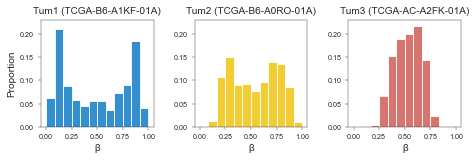

In [50]:
data = {'tumor':{'beta_values_balancedSites':
        pd.read_table(os.path.join(TCGA_clinical_dir, 'cohort1.methyl.balancedSites.tsv'),
                      index_col=0)
       }}

sample_list = {'Tum1':'TCGA-B6-A1KF-01A',
               'Tum2':'TCGA-B6-A0RO-01A',
               'Tum3':'TCGA-AC-A2FK-01A'}

chosen_tumor_colors = [consts['palette_jco'][i] for i in [0, 1, 3]]

# m_util.plotTumorWise(data, CpG_list=balanced_CpGs_final_set, sample_list=[sample_list[tum] for tum in sample_list],
m_util.plotTumorWise(data, data_obj='beta_values_balancedSites', sample_list=[sample_list[tum] for tum in sample_list],
                     suptitle='', xlabel='β', title_formats=[tum + ' ({})' for tum in sample_list],
                     outfile=True, outdir=figure_outdir, outfile_name='example_tumors.pdf',
                     choose_random=False, color=chosen_tumor_colors,
                     ylim=(0, 0.23), bins=12,
                     figsize=figsize * [2.3, 0.8], text_fontsize=labelfontsize, ticksfontsize=ticksfontsize, opacity=opacity, sf=sf,
                     tight_layout_pad=0.2
             )

In [25]:
sampleToPatientID = lambda x:'-'.join(x.split('-')[:3])

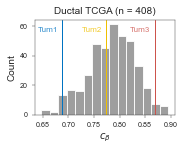

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize * [1, 0.8] * sf)
fig.tight_layout(pad=1)

sns.histplot(ax=ax, x=clinical['TCGA'].loc[clinical['TCGA']['in_analysis_dataset'], 'c_beta'],
             color=consts['palette_jco'][2], alpha=opacity)

x_0 = clinical['TCGA'].loc[sampleToPatientID(sample_list['Tum1']), 'c_beta']
x_1 = clinical['TCGA'].loc[sampleToPatientID(sample_list['Tum2']), 'c_beta']
x_2 = clinical['TCGA'].loc[sampleToPatientID(sample_list['Tum3']), 'c_beta']


ax.axvline(x=x_0, lw=2.5 * sf, color=chosen_tumor_colors[0])
ax.axvline(x=x_1, lw=2.5 * sf, color=chosen_tumor_colors[1])
ax.axvline(x=x_2, lw=2.5 * sf, color=chosen_tumor_colors[2])

ax.set_xlabel('$c_β$', fontsize=labelfontsize * sf)
ax.set_ylabel('Count', fontsize=labelfontsize * sf)
ax.set_title(f"Ductal TCGA (n = {clinical['TCGA']['in_analysis_dataset'].sum()})", fontsize=labelfontsize * sf)
ax.tick_params(axis='both', labelsize=ticksfontsize * sf, width=sf, length=8 * sf)

ax.text(x_0*0.99, ax.get_ylim()[1]*7/8,
        'Tum1', color=chosen_tumor_colors[0],
        ha="right", fontfamily='sans-serif', fontsize=0.8 * labelfontsize * sf, alpha=opacity
       )
ax.text(x_1*0.99, ax.get_ylim()[1]*7/8,
        'Tum2', color=chosen_tumor_colors[1],
        ha="right", fontfamily='sans-serif', fontsize=0.8 * labelfontsize * sf, alpha=opacity
       )
ax.text(x_2*0.99, ax.get_ylim()[1]*7/8,
        'Tum3', color=chosen_tumor_colors[2],
        ha="right", fontfamily='sans-serif', fontsize=0.8 * labelfontsize * sf, alpha=opacity
       )

fig.savefig(os.path.join(figure_outdir, 'c_beta_distribution.pdf'), format='pdf', pad_inches=0.1)

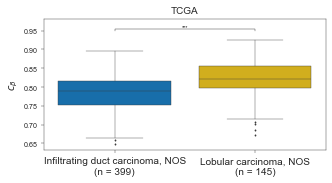

In [38]:
major_diagnoses = ['Infiltrating duct carcinoma, NOS', 'Lobular carcinoma, NOS']
ax = m_util.saveBoxPlotNew(clinical['TCGA'], 'primary_diagnosis', restrict=False,
                   var_y='c_beta',
                   outdir=figure_outdir, title=True, use_groups=major_diagnoses,
                   palette=consts['palette_jco'], signif_fontsize=signif_fontsize,
                   figsize=figsize * [1.8, 1],
                   labelfontsize=labelfontsize, ticksfontsize=ticksfontsize, sf=sf, linewidth=linewidth, fliersize=fliersize)

<Axes: title={'center': 'Lund'}, ylabel='$c_β$'>

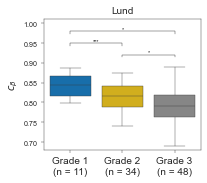

In [39]:
m_util.saveBoxPlotNew(clinical['ringner'], 'grade', restrict=True,
                   var_y='c_beta',
                   outdir=figure_outdir, title=True, use_groups=['Grade 1', 'Grade 2', 'Grade 3'],
                   palette=consts['palette_jco'],
                   figsize=figsize, labelfontsize=labelfontsize, ticksfontsize=ticksfontsize, sf=sf, linewidth=linewidth, fliersize=fliersize)

<Axes: title={'center': 'TCGA'}, ylabel='$c_β$'>

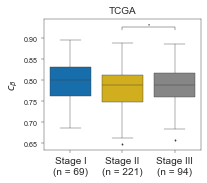

In [40]:
m_util.saveBoxPlotNew(clinical['TCGA'], 'Stage', restrict=True,
                   var_y='c_beta',
                   outdir=figure_outdir, title=True, use_groups = ['Stage I', 'Stage II', 'Stage III'],
                   palette=consts['palette_jco'],
                   figsize=figsize, labelfontsize=labelfontsize, ticksfontsize=ticksfontsize, sf=sf, linewidth=linewidth, fliersize=fliersize)

<Axes: title={'center': 'TCGA'}, ylabel='$c_β$'>

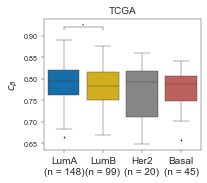

In [41]:
m_util.saveBoxPlotNew(clinical['TCGA'], 'subtype', restrict=True,
                   var_y='c_beta',
                   outdir=figure_outdir, title=True, use_groups = ['LumA', 'LumB', 'Her2', 'Basal'],
                   palette=consts['palette_jco'],
                   figsize=figsize, labelfontsize=labelfontsize, ticksfontsize=ticksfontsize, sf=sf, linewidth=linewidth, fliersize=fliersize)

In [30]:
## Ignore

clinical_TCGA_old = consts['project_data_func_dict']['TCGA']['sample_annotations']()
pureSamples_TCGA_old = consts['project_data_func_dict']['TCGA']['pureSamples']()
old_analysis_sampleUUIDs = np.intersect1d(pureSamples_TCGA_old, clinical_TCGA_old.index[clinical_TCGA_old['primary_diagnosis'] == 'Infiltrating duct carcinoma, NOS'])

all_caseuuid_caseid = pd.read_table(os.path.join(consts['ALL_dir'], 'all_caseuuid_caseid.tsv'), index_col=0).squeeze('columns')
all_caseuuid_caseid.index = all_caseuuid_caseid.index.str.upper()
assert np.isin(clinical_TCGA_old.loc[old_analysis_sampleUUIDs, 'cases.0.case_id'], all_caseuuid_caseid.index).all()
clinical_TCGA_old = clinical_TCGA_old.merge(all_caseuuid_caseid, left_on='cases.0.case_id', right_index=True)

old_analysis_submitterIDs = clinical_TCGA_old.loc[old_analysis_sampleUUIDs, 'submitter_id']

a = clinical['TCGA'].loc[clinical['TCGA']['in_analysis_dataset'] & (clinical['TCGA']['subtype'] == 'Her2'), 'c_beta']
b = clinical['TCGA'].loc[clinical['TCGA'].index.isin(old_analysis_submitterIDs) & clinical['TCGA']['in_analysis_dataset'] & (clinical['TCGA']['subtype'] == 'Her2'), 'c_beta']

# why is this nan?
# clinical['TCGA'].loc['TCGA-E9-A22G', 'c_beta']

print(a.dropna().shape)
print(b.dropna().shape)
print(a.median())
print(b.median())

(20,)
(15,)
0.791885868928601
0.7527160617030171


<Axes: title={'center': 'Lund'}, ylabel='$c_β$'>

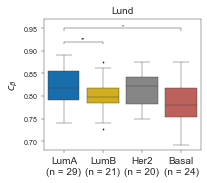

In [44]:
m_util.saveBoxPlotNew(clinical['ringner'], 'genefu.pam50.subtype', restrict=True,
                   var_y='c_beta',
                   outdir=figure_outdir, title=True, use_groups = ['LumA', 'LumB', 'Her2', 'Basal'],
                   palette=consts['palette_jco'],
                   figsize=figsize, labelfontsize=labelfontsize, ticksfontsize=ticksfontsize, sf=sf, linewidth=linewidth, fliersize=fliersize)

<Axes: title={'center': 'TCGA'}, ylabel='$c_β$'>

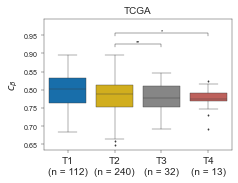

In [55]:
m_util.saveBoxPlotNew(clinical['TCGA'], 'T Stage', restrict=True,
                   var_y='c_beta',
                   outdir=figure_outdir, title=True, use_groups = ['T1', 'T2', 'T3', 'T4'],
                   palette=consts['palette_jco'],
                   figsize=figsize * [1.2, 1], labelfontsize=labelfontsize, ticksfontsize=ticksfontsize, sf=sf, linewidth=linewidth, fliersize=fliersize)

In [52]:
## Ignore

from statsmodels.miscmodels.ordinal_model import OrderedModel
from pandas.api.types import CategoricalDtype

T_stage_cats = ['T1', 'T2', 'T3', 'T4']

model_data = clinical['TCGA'].loc[clinical['TCGA']['T Stage'].isin(T_stage_cats),
                                  ['T Stage', 'c_beta']].dropna()
model_data['T Stage'] = model_data['T Stage'].astype(
    CategoricalDtype(categories=T_stage_cats, ordered=True)
)

mod_prob = OrderedModel(model_data['T Stage'],
                        model_data['c_beta'],
                        distr='probit')



res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

Optimization terminated successfully.
         Current function value: 1.066222
         Iterations: 17
         Function evaluations: 18
         Gradient evaluations: 18


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                T Stage   Log-Likelihood:                -661.06
Model:                   OrderedModel   AIC:                             1330.
Method:            Maximum Likelihood   BIC:                             1348.
Date:                Tue, 16 Apr 2024                                         
Time:                        02:32:11                                         
No. Observations:                 620                                         
Df Residuals:                     616                                         
Df Model:                           1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c_beta        -0.8957      0.883     -1.014      0.311      -2.627       0.836
T1/T2         -1.3795      0.703     -1.963      0.050      -2.757      -0.002
T2/T3          0.4555      0.043     10.505      0.000       0.370       0.540
T3/T4         -0.0829      0.099     -0.838      0.402      -0.277       0.111
==============================================================================
"""

<Axes: title={'center': 'Subtype (Luminal Grouped) (Cohort T1)'}, ylabel='$c_β$'>

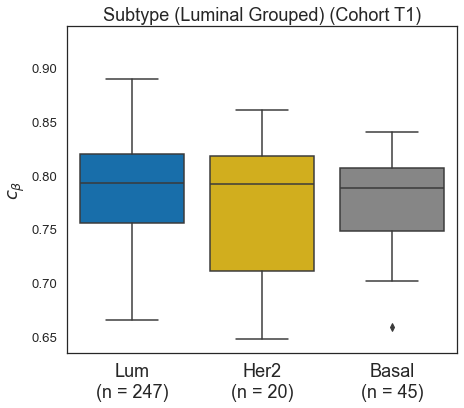

In [280]:
clinical['TCGA']['subtype_lumGrouped'] = clinical['TCGA']['subtype'].copy().map({'LumA':'Lum', 'LumB':'Lum', 'Her2':'Her2', 'Basal':'Basal'})

m_util.saveBoxPlotNew(clinical['TCGA'], 'subtype_lumGrouped', restrict=True,
                   var_y='c_beta',
                      use_groups = ['Lum', 'Her2', 'Basal'],
                   figsize=(7, 6),
                      label = 'Subtype (Luminal Grouped)',
                   outdir=figure_outdir, title=True,
                   palette=consts['palette_jco'])

<Axes: title={'center': 'Subtype (Luminal Grouped) (Cohort T2)'}, ylabel='$c_β$'>

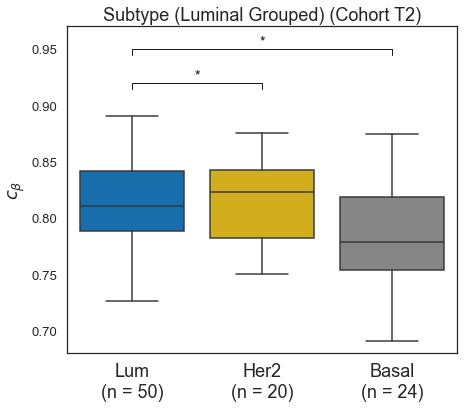

In [281]:
clinical['ringner']['subtype_lumGrouped'] = clinical['ringner']['genefu.pam50.subtype'].copy().map({'LumA':'Lum', 'LumB':'Lum', 'Her2':'Her2', 'Basal':'Basal'})

m_util.saveBoxPlotNew(clinical['ringner'], 'subtype_lumGrouped', restrict=True,
                   var_y='c_beta',
                      use_groups = ['Lum', 'Her2', 'Basal'],
                   figsize=(7, 6),
                      label = 'Subtype (Luminal Grouped)',
                   outdir=figure_outdir, title=True,
                   palette=consts['palette_jco'])

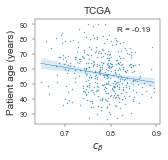

In [19]:
m_util.saveCorrelationPlot(clinical['TCGA'], var_y='age', restrict=True,
                           var_x='c_beta',
                           outdir=figure_outdir, label='Patient age (years)',
                           text_x=0.85, text_y=85,
                           figsize=figsize * 0.8, labelfontsize=labelfontsize, ticksfontsize=ticksfontsize, sf=sf, s=1,
                           color=consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

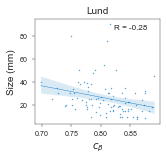

In [22]:
m_util.saveCorrelationPlot(clinical['ringner'], var_y='size', restrict=True,
                           var_x='c_beta',
                           outdir=figure_outdir, label='Size (mm)',
                           text_x=0.85, text_y=85,
                           figsize=figsize * 0.8, labelfontsize=labelfontsize, ticksfontsize=ticksfontsize, sf=sf, s=1,
                           color=consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

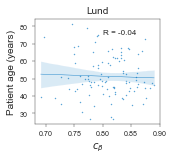

In [25]:
m_util.saveCorrelationPlot(clinical['ringner'], var_y='age', restrict=True,
                           var_x='c_beta',
                           outdir=figure_outdir, label='Patient age (years)',
                           text_x=0.83, text_y=75,
                           figsize=figsize * 0.8, labelfontsize=labelfontsize, ticksfontsize=ticksfontsize, sf=sf, s=1,
                           color=consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

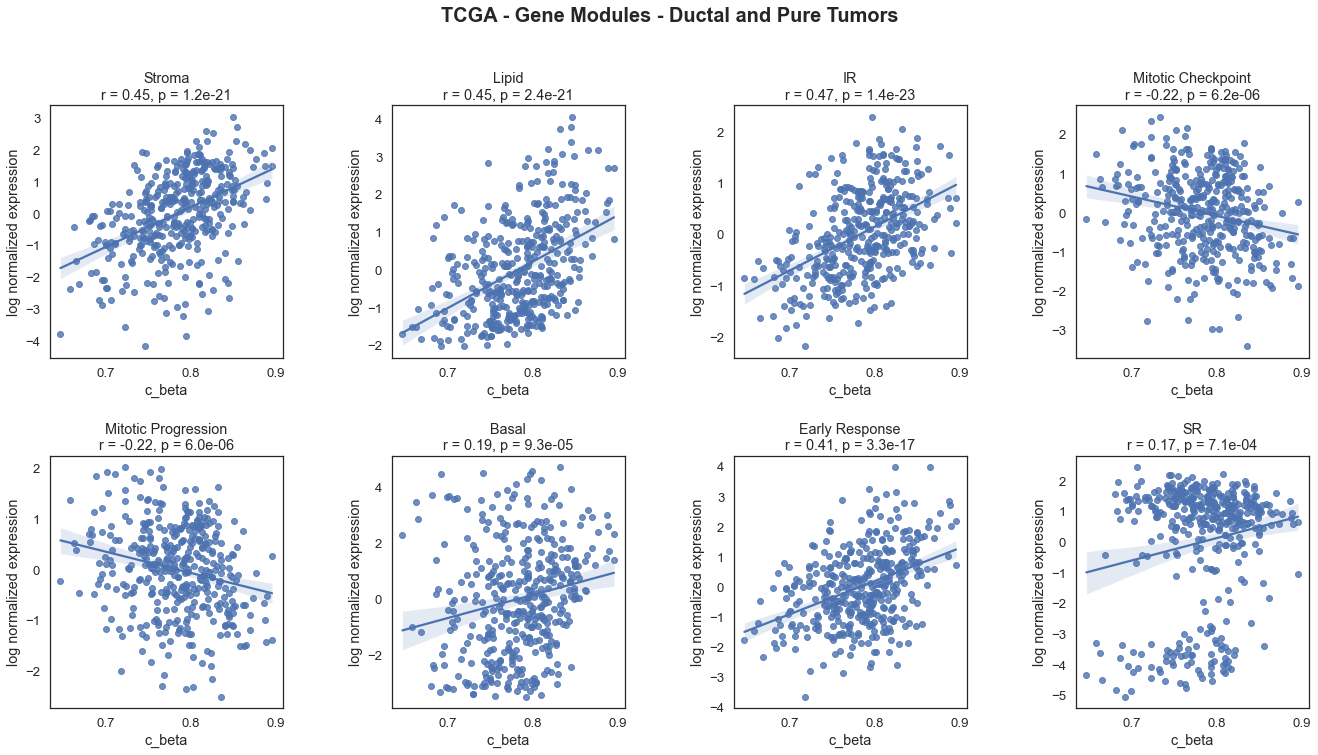

In [285]:
## Ignore

##### NEW
##### 3-25-24
##### Investigating issue of difference in correlation values

ncols = 4
nrows = 2

fig, axes = plt.subplots(nrows, ncols, figsize=(20, 2 + 5*nrows))
fig.suptitle(f'TCGA - Gene Modules - Ductal and Pure Tumors', y=0.92, fontsize=20, fontweight='bold')
fig.tight_layout(pad=5)

plot_df = clinical['TCGA'].loc[clinical['TCGA']['in_analysis_dataset']]

for i, module in enumerate(consts['gene_module_dict'].keys()):
    row = int(i // ncols)
    col = i % ncols
    
    ax = axes[row, col]
    
    ser1 = plot_df['c_beta']
    ser2 = plot_df[module]
    corr = m_util.pearsonCorrelation(ser1, ser2)
    sns.regplot(ax=ax, x=ser1, y=ser2)
    ax.set_title(f'{module}\nr = {corr.rvalue:.2f}, p = {corr.pvalue:.1e}')
    ax.set_ylabel('log normalized expression')
    ax.set_xlabel('c_beta')

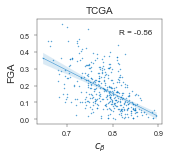

In [23]:
m_util.saveCorrelationPlot(clinical['TCGA'], var_y='FGA', restrict=True,
                           var_x='c_beta',
                           outdir=figure_outdir, label='FGA',
                           text_x=0.85, text_y=0.5,
                           figsize=figsize * 0.8, labelfontsize=labelfontsize, ticksfontsize=ticksfontsize, sf=sf, s=1,
                           color=consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

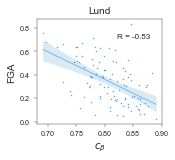

In [24]:
m_util.saveCorrelationPlot(clinical['ringner'], var_y='FGA', restrict=True,
                           var_x='c_beta',
                           outdir=figure_outdir, label='FGA',
                           text_x=0.85, text_y=0.7,
                           figsize=figsize * 0.8, labelfontsize=labelfontsize, ticksfontsize=ticksfontsize, sf=sf, s=1,
                           color=consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

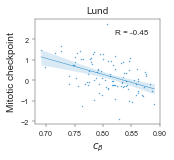

In [25]:
m_util.saveCorrelationPlot(clinical['ringner'], var_y='Mitotic Checkpoint', restrict=True,
                           var_x='c_beta',
                           outdir=figure_outdir,
                           text_x=0.85, text_y=2.2,
                           figsize=figsize * 0.8, labelfontsize=labelfontsize, ticksfontsize=ticksfontsize, sf=sf, s=1,
                           color=consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )


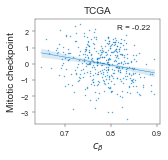

In [28]:
m_util.saveCorrelationPlot(clinical['TCGA'], var_y='Mitotic Checkpoint', restrict=True,
                           var_x='c_beta',
                           outdir=figure_outdir,
                           text_x=0.85, text_y=2.1,
                           figsize=figsize * 0.8, labelfontsize=labelfontsize, ticksfontsize=ticksfontsize, sf=sf, s=1,
                           color=consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

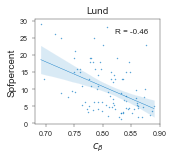

In [29]:
m_util.saveCorrelationPlot(clinical['ringner'], var_y='spfPercent', restrict=True,
                           var_x='c_beta',
                           outdir=figure_outdir,
                           text_x=0.85, text_y=26,
                           figsize=figsize * 0.8, labelfontsize=labelfontsize, ticksfontsize=ticksfontsize, sf=sf, s=1,
                           color=consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

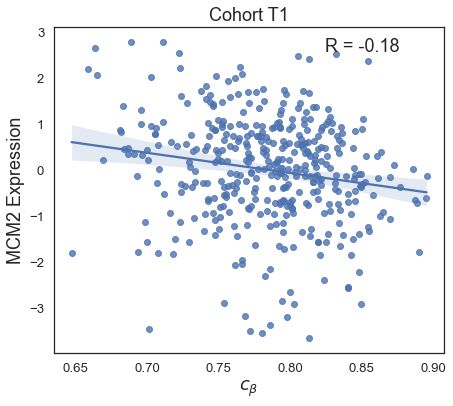

In [291]:
m_util.saveCorrelationPlot(clinical['TCGA'], var_y='MCM2', restrict=True, outfile=True,
                           outdir=figure_outdir,
                           figsize=(7, 6),
                           label='MCM2 Expression',
                           text_x=0.85, text_y=2.5, text_fontsize=18
                          )

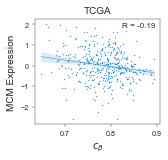

In [33]:
m_util.saveCorrelationPlot(clinical['TCGA'], var_y='MCM', restrict=True,
                           var_x='c_beta',
                           outdir=figure_outdir,
                           text_x=0.86, text_y=1.8, label='MCM Expression',
                           figsize=figsize * 0.8, labelfontsize=labelfontsize, ticksfontsize=ticksfontsize, sf=sf, s=1,
                           color=consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

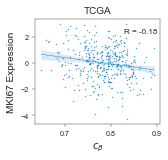

In [37]:
m_util.saveCorrelationPlot(clinical['TCGA'], var_y='MKI67', restrict=True,
                           var_x='c_beta',
                           outdir=figure_outdir,
                           text_x=0.865, text_y=2.2, label='MKI67 Expression',
                           figsize=figsize * 0.8, labelfontsize=labelfontsize, ticksfontsize=ticksfontsize, sf=sf, s=1,
                           color=consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

In [49]:
gene_list = markers_transformed_df.index.values # list of genes to search
use_samples = clinical['TCGA'].index[clinical['TCGA']['in_analysis_dataset']] # list of samples to use - make sure these are only pure ductal samples

c_beta_use_samples = clinical['TCGA'].loc[use_samples, 'c_beta']
markers_transformed_df_use_samples = markers_transformed_df[use_samples]

rvalue_list = []
for i in range(len(gene_list)):
    if i % 5000 == 0:
        print(i)
    #
#     res = linregress(c_beta_use_samples, markers_vals_use_samples.loc[gene_list[i]])
    
    res = m_util.pearsonCorrelation(c_beta_use_samples, markers_transformed_df_use_samples.loc[gene_list[i]])
    rvalue_list.append(res.rvalue)

rvalue_ser = pd.Series(index=gene_list, data=rvalue_list).sort_values()

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000


In [50]:
rvalue_ser = pd.Series(index=gene_list, data=rvalue_list)

In [70]:
genenames_proteincoding = pd.read_table(os.path.join(consts['official_indir'], 'misc', 'genenames.proteincoding.txt'),
                                       low_memory=False, usecols=['symbol']).squeeze('columns').values

In [76]:
np.intersect1d(genenames_proteincoding, gene_name).shape

(18910,)

In [109]:
np.mean(np.isin(consts['all_module_genes'], genenames_proteincoding))

0.9893048128342246

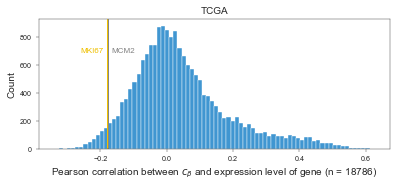

In [131]:
fig, ax = plt.subplots(1, 1, figsize=figsize * [2, 1] * sf)
fig.tight_layout(pad=1)

plot_data = rvalue_ser[gene_name.isin(genenames_proteincoding)]
sns.histplot(ax=ax, x=plot_data,
             color=consts['palette_jco'][0])
MKI67_corr = rvalue_ser.loc[gene_name.index[gene_name == 'MKI67']].values
MCM2_corr = rvalue_ser.loc[gene_name.index[gene_name == 'MCM2']].values

assert len(MKI67_corr) == 1
assert len(MCM2_corr) == 1
ax.axvline(x=MKI67_corr[0], color=consts['palette_jco'][1], lw=2.5 * sf)
ax.axvline(x=MCM2_corr[0], color=consts['palette_jco'][2], lw=2.5 * sf)

ax.text(MKI67_corr[0]*1.05, ax.get_ylim()[1]*3/4, 'MKI67',
                        ha="right", fontfamily='sans-serif', fontsize=labelfontsize * 0.8 * sf, color=consts['palette_jco'][1]
                       )
ax.text(MCM2_corr[0]*0.95, ax.get_ylim()[1]*3/4, 'MCM2',
                        ha="left", fontfamily='sans-serif', fontsize=labelfontsize * 0.8 * sf, color=consts['palette_jco'][2]
                       )
ax.set_ylabel('Count', fontsize=labelfontsize * sf)
ax.set_xlabel(f'Pearson correlation between $c_β$ and expression level of gene (n = {len(plot_data)})', fontsize=labelfontsize * sf)
ax.set_title(f'TCGA', fontsize=labelfontsize * sf)
ax.tick_params(axis='both', labelsize=ticksfontsize * sf, width=sf, length=8 * sf)

fig.savefig(os.path.join(figure_outdir, 'all_gene_correlations.pdf'), format='pdf', pad_inches=0.1)